In [3]:
from __future__ import absolute_import, division, print_function

import os
import tqdm
import cv2
import numpy as np
import pdb

cv2.setNumThreads(0)  
ROBOTCAR_SCALE_FACTOR = 0.239983*100.


In [4]:
def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3


In [5]:

def evaluate(pred_disps, gt_depths):
    """Evaluates a pretrained model using a specified test set
    """
    MIN_DEPTH = 1e-3
    MAX_DEPTH = 50
    eval_split = "normal"
    print("-> Evaluating")

    errors = []
    all_ratios = []
    frame_timestamps = '/home/madhu/code/feature-slam/datasets/robotcar/2014-12-16-18-44-24_test.txt'
    timestamps = np.loadtxt(frame_timestamps, dtype=str)
    timestamps = timestamps[:,0]

    for i in tqdm.tqdm(range(pred_disps.shape[0]),total = pred_disps.shape[0]):


        #[0.20610779 2.50589489 9.03905365 0.37457745 0.59337944 0.79590947 0.90455592]

        gt_depth = gt_depths[i]
        gt_height, gt_width = gt_depth.shape[:2]

        pred_disp = pred_disps[i]
    
        pred_disp = cv2.resize(pred_disp, (gt_width, gt_height))
        pred_depth = ROBOTCAR_SCALE_FACTOR / (pred_disp + 1e-6)

        if eval_split == "eigen":
            mask = np.logical_and(gt_depth > MIN_DEPTH, gt_depth < MAX_DEPTH)

            crop = np.array([0.40810811 * gt_height, 0.99189189 * gt_height,
                             0.03594771 * gt_width,  0.96405229 * gt_width]).astype(np.int32)
            crop_mask = np.zeros(mask.shape)
            crop_mask[crop[0]:crop[1], crop[2]:crop[3]] = 1
            mask = np.logical_and(mask, crop_mask)

        else:
            mask = np.logical_and(gt_depth > MIN_DEPTH, gt_depth < MAX_DEPTH)

        if mask.sum() == 0:
            print("mask sum is 0")
            continue

        #ratio = np.median(gt_depth[mask]) / np.median(pred_depth[mask])
        #pred_depth *= ratio
        #all_ratios.append(ratio)

        pred_depth = pred_depth[mask]
        gt_depth = gt_depth[mask]

        pred_depth[pred_depth < MIN_DEPTH] = MIN_DEPTH
        pred_depth[pred_depth > MAX_DEPTH] = MAX_DEPTH

        cur_frame_error = compute_errors(gt_depth, pred_depth)
        cur_frame_error = [timestamps[i], i] + list(cur_frame_error)
        errors.append(cur_frame_error)

    return np.array(errors)

In [6]:
gt_depths_path = '/hdd1/madhu/data/robotcar/2014-12-16-18-44-24/depth_evaluation/gt_depths.npy'
print("-> Loading ground truth from ",gt_depths_path)
gt_depths = np.load(gt_depths_path, allow_pickle=True)

-> Loading ground truth from  /hdd1/madhu/data/robotcar/2014-12-16-18-44-24/depth_evaluation/gt_depths.npy


In [7]:
pred_disp_path = '/mnt/nas/madhu/data/predictions/chapter_4_cvpr/icra_2024.npy'
print("-> Loading predictions from ",pred_disp_path)
pred_disps = np.load(pred_disp_path)

-> Loading predictions from  /mnt/nas/madhu/data/predictions/chapter_4_cvpr/icra_2024.npy


In [13]:
results  = evaluate(pred_disps, gt_depths)
print(results)

-> Evaluating


  7%|▋         | 50/716 [00:00<00:05, 129.42it/s]

mask sum is 0


 86%|████████▌ | 613/716 [00:04<00:00, 126.94it/s]

mask sum is 0
mask sum is 0


 92%|█████████▏| 658/716 [00:05<00:00, 138.71it/s]

mask sum is 0
mask sum is 0
mask sum is 0
mask sum is 0


100%|██████████| 716/716 [00:05<00:00, 127.55it/s]

[['1418756715923425' '0' '0.16978181500461315' ... '0.7281798050245628'
  '0.8892763509557869' '0.9539542342250618']
 ['1418756716173391' '1' '0.17092219198199318' ... '0.7074865773495911'
  '0.8857945707260776' '0.9568468061618747']
 ['1418756716423357' '2' '0.1854924896232598' ... '0.679830887838846'
  '0.8667246953494155' '0.9421039542402387']
 ...
 ['1418757060189400' '713' '0.16179339542875001' ... '0.7546072642691'
  '0.9055063517623904' '0.9715959921273931']
 ['1418757060501858' '714' '0.16760097240377972' ... '0.753129760879645'
  '0.9028946148241372' '0.9522642467598419']
 ['1418757060751824' '715' '0.15469537074544418' ... '0.7779205814571885'
  '0.9039399042722921' '0.9535321751462507']]


In [14]:
stamps = results[:,0]
original_inds = results[:,1]
errors = results[:,2:].astype(np.float32)
rmse = errors[:,2]
top_9_rmse_inds = np.argsort(rmse)[::-1][9:18]
print(rmse[top_9_rmse_inds])
top_9_stamps = stamps[top_9_rmse_inds]
ref_inds = original_inds[top_9_rmse_inds].astype(np.int32)
print(ref_inds)

[12.585997 12.513726 12.481278 12.379456 12.366258 12.250639 12.237352
 12.148703 12.087948]
[438 432 427 509 512 511 428 424 431]


In [10]:
image_folder_path = '/hdd1/madhu/data/robotcar/depth_test_splits/2014-12-16-18-44-24/stereo/left'
assert os.path.exists(image_folder_path)

images = []

for i in range(len(top_9_stamps)):
    path = os.path.join(image_folder_path, top_9_stamps[i] + '.png')
    assert os.path.exists(path)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)



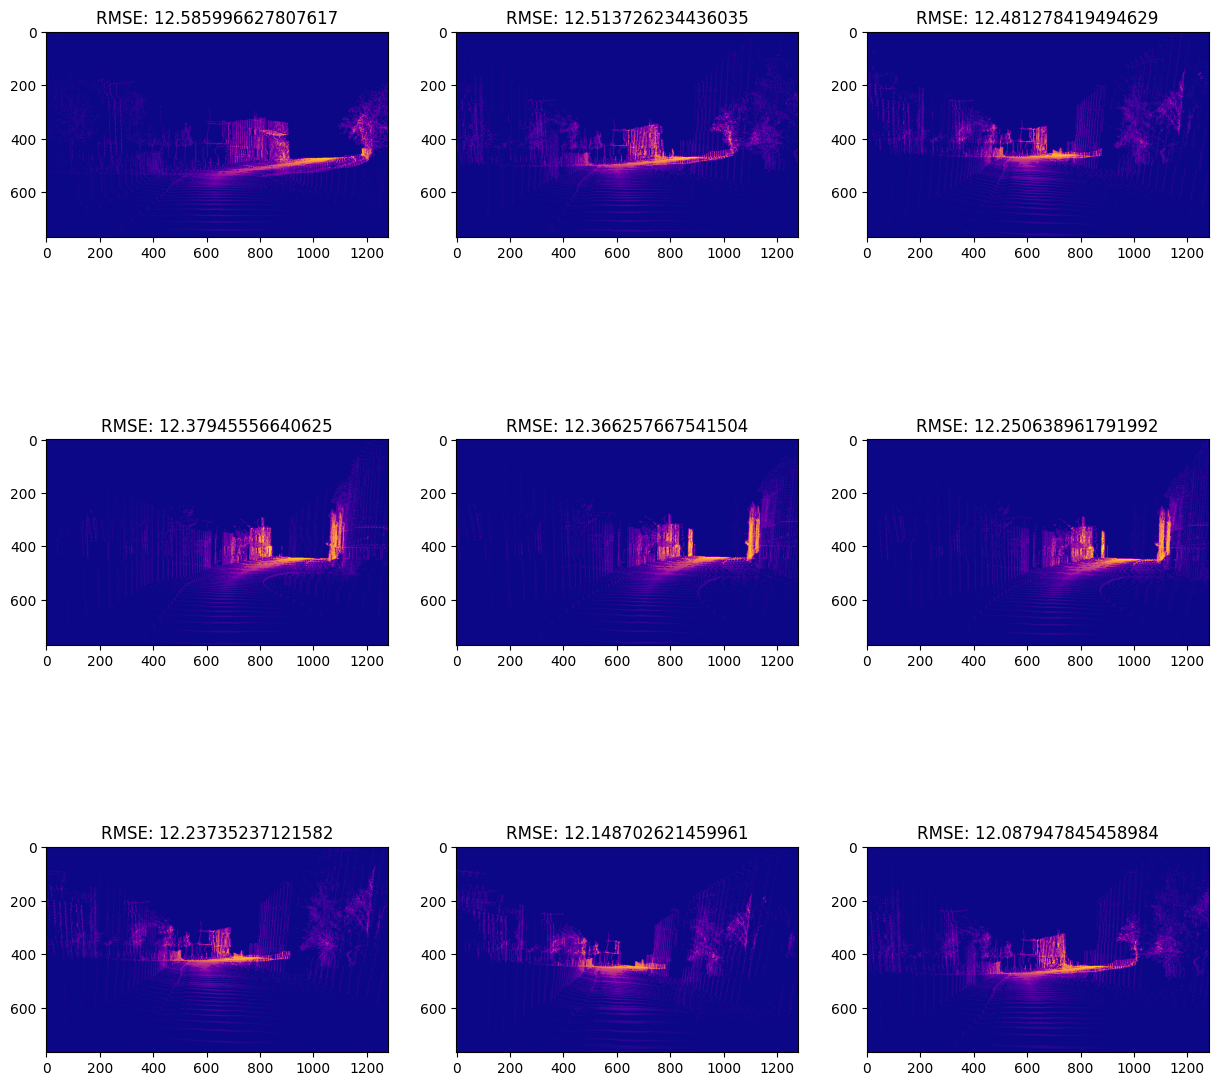

In [11]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(3,3, figsize=(15,15))
axes = axes.flatten()
for i,ind in enumerate(ref_inds):
    axes[i].imshow(gt_depths[ind],cmap='plasma')
    axes[i].set_title("RMSE: {}".format(rmse[top_9_rmse_inds[i]]))
plt.show()




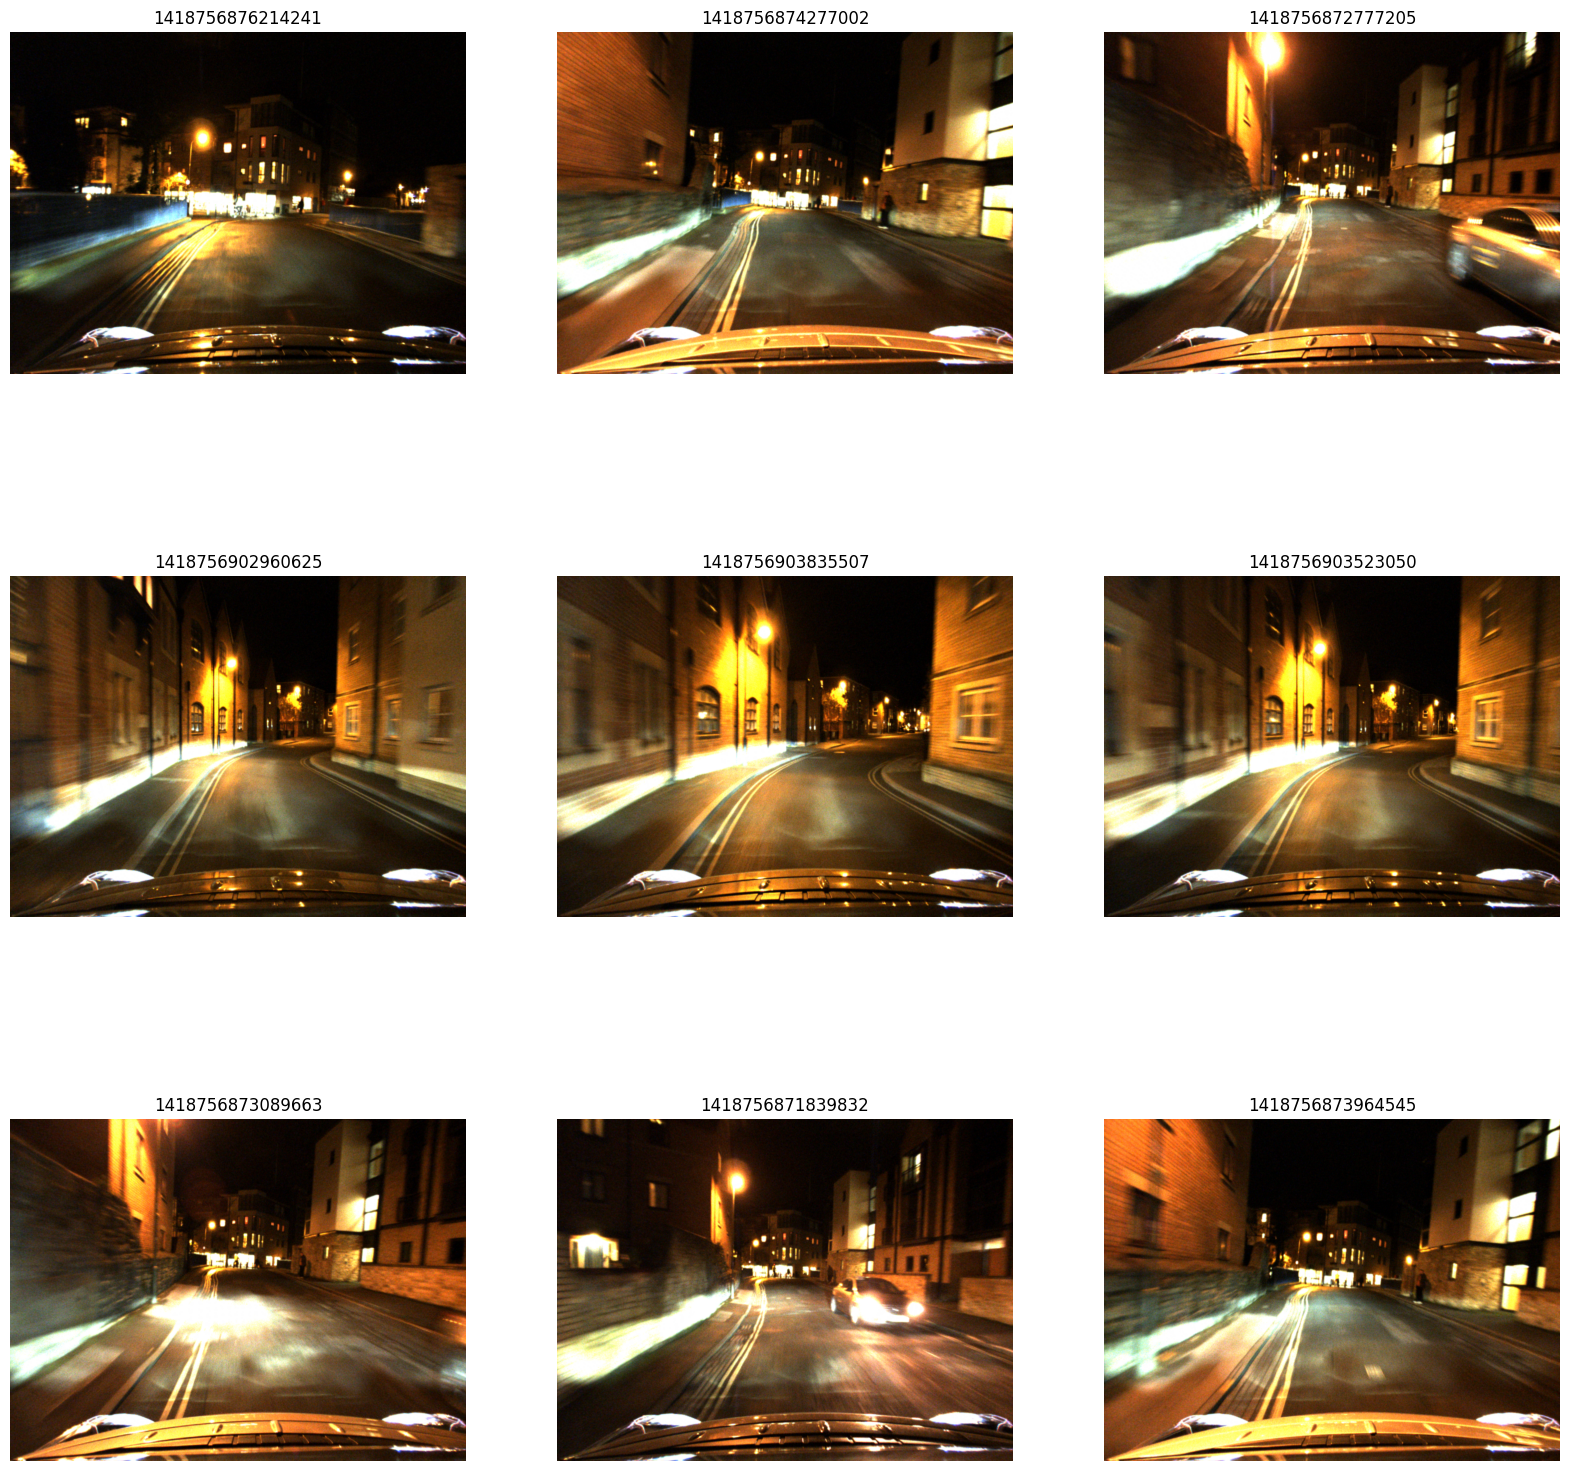

In [12]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(3,3, figsize=(20,20))
axes = axes.flatten()
for i in range(len(images)):
    axes[i].imshow(images[i])
    axes[i].set_title(top_9_stamps[i])
    axes[i].axis('off')
plt.show()